In [6]:
import os
from glob import glob
import clip
import torch
from PIL import Image
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# --- 1. Setup CLIP Model and Preprocessing ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# --- 2. Embedding Functions ---
def encode_image(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features.squeeze().cpu().tolist()

def encode_text(text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features.squeeze().cpu().tolist()

# --- 3. Index Images if Needed ---
def index_images_if_required(image_folder, collection):
    image_files = glob(os.path.join(image_folder, "*.[jp][pn]g"))

    if len(collection.schema.fields) > 1 and collection.num_entities > 0:
        print(f"[✓] Collection already contains {collection.num_entities} vectors. Skipping indexing.")
        return

    print(f"[+] Indexing {len(image_files)} images...")
    ids, vectors, filepaths = [], [], []

    for idx, img_path in enumerate(image_files):
        try:
            emb = encode_image(img_path)
            ids.append(idx)
            vectors.append(emb)
            filepaths.append(img_path)
        except Exception as e:
            print(f"[!] Skipping {img_path}: {e}")

    collection.insert([ids, vectors, filepaths])
    print("[✓] Indexing complete.")

if __name__ == "__main__":
    image_folder = "/kaggle/input/coco-2017-dataset/coco2017/val2017"  # <-- dynamic folder
    db_path = os.path.join('/kaggle/working/', "milvus_lite.db")
    COLLECTION_NAME = "image_collection"

    # Connect to per-folder Milvus Lite DB
    connections.connect(alias="default", uri=db_path)

    # Define collection schema
    if not utility.has_collection(COLLECTION_NAME):
        sample_img = next(f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
        emb_dim = len(encode_image(os.path.join(image_folder, sample_img)))

        fields = [
            FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False),
            FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=emb_dim),
            FieldSchema(name="filepath", dtype=DataType.VARCHAR, max_length=512)
        ]
        schema = CollectionSchema(fields, description="CLIP-embedded image collection")
        collection = Collection(COLLECTION_NAME, schema=schema)
        print("[+] Created new collection.")
    else:
        collection = Collection(COLLECTION_NAME)
        print("[✓] Loaded existing collection.")

    # Index only if empty
    index_images_if_required(image_folder, collection)

    # Create index if not already created
    index_info = collection.indexes
    if not index_info:
        collection.create_index("vector", {"index_type": "FLAT", "metric_type": "COSINE", "params": {}})
        print("[+] Created index.")

[+] Created new collection.
[+] Indexing 5000 images...
[✓] Indexing complete.
[+] Created index.


[✓] Loaded existing collection.
[✓] Collection already contains 5000 vectors. Skipping indexing.
[✓] Collection loaded into memory.


Enter your query:  park


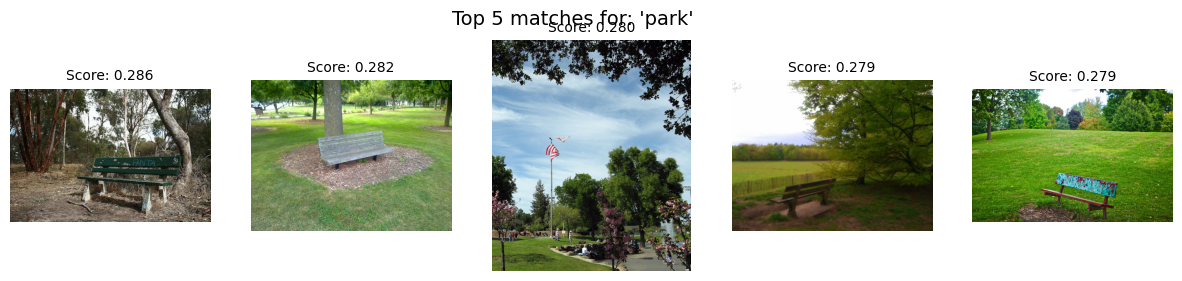

Top image paths: ['/kaggle/input/coco-2017-dataset/coco2017/val2017/000000527960.jpg', '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000506454.jpg', '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000374545.jpg', '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000162130.jpg', '/kaggle/input/coco-2017-dataset/coco2017/val2017/000000314541.jpg']


In [11]:
import matplotlib.pyplot as plt

def search_and_show(query, collection, top_k=5):
    query_emb = encode_text(query)

    results = collection.search(
        data=[query_emb],
        anns_field="vector",
        param={"metric_type": "COSINE", "params": {}},
        limit=top_k,
        output_fields=["filepath"]
    )

    # Collect results
    filepaths = [hit.entity.get('filepath') for hit in results[0]]
    scores = [hit.score for hit in results[0]]

    # Display results
    plt.figure(figsize=(15, 3))
    for i, (fp, sc) in enumerate(zip(filepaths, scores)):
        plt.subplot(1, top_k, i + 1)
        plt.imshow(Image.open(fp))
        plt.title(f"Score: {sc:.3f}", fontsize=10)
        plt.axis("off")
    plt.suptitle(f"Top {top_k} matches for: '{query}'", fontsize=14)
    plt.show()

    return filepaths

# --- 5. Main ---
if __name__ == "__main__":
    image_folder = "/kaggle/input/coco-2017-dataset/coco2017/val2017"  # <-- dynamic folder
    db_path = os.path.join('/kaggle/working/', "milvus_lite.db")
    COLLECTION_NAME = "image_collection"

    # Connect to Milvus Lite DB
    connections.connect(alias="default", uri=db_path)

    # Define collection schema
    if not utility.has_collection(COLLECTION_NAME):
        sample_img = next(f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
        emb_dim = len(encode_image(os.path.join(image_folder, sample_img)))

        fields = [
            FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False),
            FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=emb_dim),
            FieldSchema(name="filepath", dtype=DataType.VARCHAR, max_length=512)
        ]
        schema = CollectionSchema(fields, description="CLIP-embedded image collection")
        collection = Collection(COLLECTION_NAME, schema=schema)
        print("[+] Created new collection.")
    else:
        collection = Collection(COLLECTION_NAME)
        print("[✓] Loaded existing collection.")

    # Index only if empty
    index_images_if_required(image_folder, collection)

    # Create index if not already created
    index_info = collection.indexes
    if not index_info:
        collection.create_index("vector", {"index_type": "FLAT", "metric_type": "COSINE", "params": {}})
        print("[+] Created index.")

    # Load and search interactively
    collection.load()
    print("[✓] Collection loaded into memory.")

    prompt = input("Enter your query: ")
    top_images = search_and_show(prompt, collection)
    print("Top image paths:", top_images)
